## Bayesian Neural Network

In [3]:
# Importing libraries
from laplace import Laplace
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch.distributions as dist
import jax.tree_util as jtu

torch.manual_seed(42)

### Training a simple neural network on the dataset below

In [2]:
# Dataset generation
X = np.linspace(0, 1, 300)
noise = np.random.normal(0, 0.1, 300)
y = np.sin(2 * np.pi * X) + noise

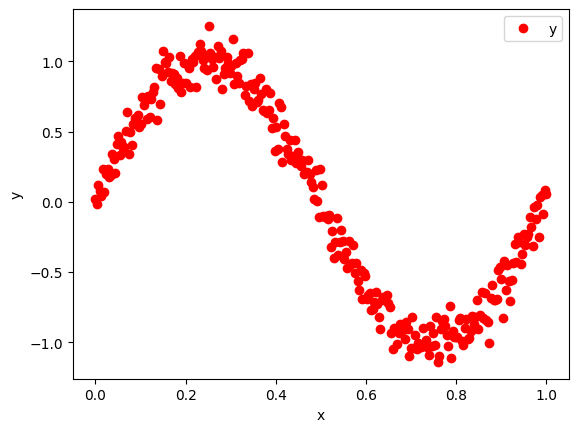

In [3]:
# Plot the data
plt.plot(X, y, 'ro', label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [4]:
# Creating torch tensors of the data
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [5]:
# Reshaping the data
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)   

In [6]:
# Creating a neural network with 1 hidden layer
nn_model = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.Tanh(),
    torch.nn.Linear(5, 1),
)

In [7]:
list(nn_model.parameters())

[Parameter containing:
 tensor([[ 0.7645],
         [ 0.8300],
         [-0.2343],
         [ 0.9186],
         [-0.2191]], requires_grad=True),
 Parameter containing:
 tensor([ 0.2018, -0.4869,  0.5873,  0.8815, -0.7336], requires_grad=True),
 Parameter containing:
 tensor([[0.3887, 0.0837, 0.3304, 0.0606, 0.2156]], requires_grad=True),
 Parameter containing:
 tensor([-0.0631], requires_grad=True)]

In [8]:
summary(nn_model, (1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 5]                10
├─Tanh: 1-2                              [-1, 1, 5]                --
├─Linear: 1-3                            [-1, 1, 1]                6
Total params: 16
Trainable params: 16
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1, 5]                10
├─Tanh: 1-2                              [-1, 1, 5]                --
├─Linear: 1-3                            [-1, 1, 1]                6
Total params: 16
Trainable params: 16
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [9]:
# Training the neural network on the above dataset
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = nn_model(X)
    loss_fn(y_pred, y).backward()
    optimizer.step()

In [10]:
list(nn_model.parameters())

[Parameter containing:
 tensor([[ 3.5049],
         [ 3.9006],
         [-1.2160],
         [ 4.1334],
         [-1.3327]], requires_grad=True),
 Parameter containing:
 tensor([-3.7856, -1.9569, -1.0991,  0.0496,  1.3223], requires_grad=True),
 Parameter containing:
 tensor([[ 2.0889, -2.1488, -0.2644,  1.7256, -1.0963]], requires_grad=True),
 Parameter containing:
 tensor([0.6912], requires_grad=True)]

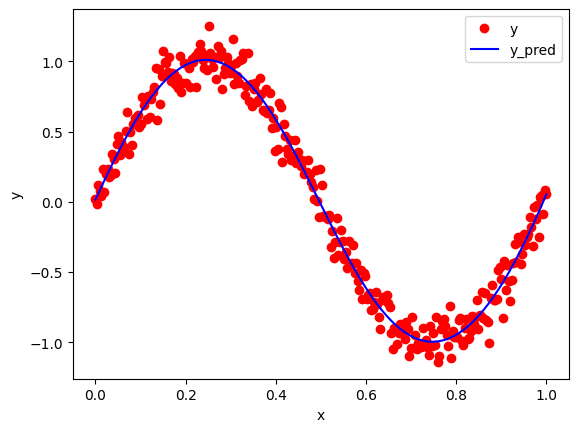

In [11]:
# Plotting the predictions of the neural network
y_pred = nn_model(X)

plt.plot(X, y, 'ro', label='y')
plt.plot(X, y_pred.detach().numpy(), 'b-', label='y_pred')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Using the Laplace library to get predictive variance

In [12]:
train_dataset = torch.utils.data.TensorDataset(X, y)

In [13]:
# Creating a torch.data.utils.DataLoader object
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)

In [14]:
la = Laplace(nn_model, likelihood = 'regression', subset_of_weights='all', hessian_structure='full')

In [15]:
la.fit(train_loader)

In [16]:
la.optimize_prior_precision()

In [17]:
la.mean

tensor([ 3.5049,  3.9006, -1.2160,  4.1334, -1.3327, -3.7856, -1.9569, -1.0991,
         0.0496,  1.3223,  2.0889, -2.1488, -0.2644,  1.7256, -1.0963,  0.6912])

In [4]:
x_test = torch.linspace(-0.5, 1.5, 400)

In [7]:
x_test.shape

torch.Size([400])

In [19]:
test_mean, test_var = la(x_test.float().reshape(-1, 1))

In [5]:
x_test.shape

torch.Size([400])

In [6]:
x_test.float().reshape(-1, 1).shape

torch.Size([400, 1])

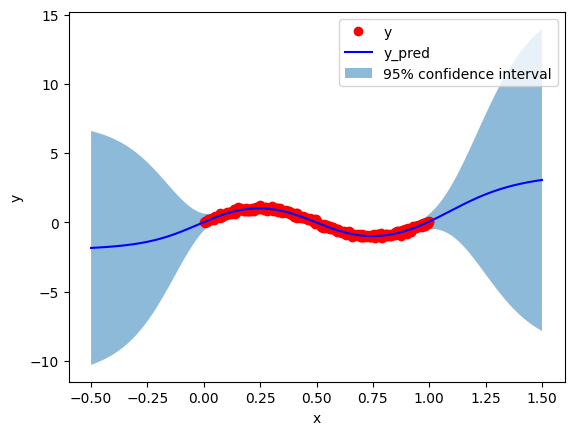

In [20]:
# Plot the predictions of the Laplace approximation and use the test_var to plot the 95% confidence interval
plt.plot(X, y, 'ro', label='y')
plt.plot(x_test, test_mean.detach().numpy(), 'b-', label='y_pred')

conf_int = 1.96 * np.sqrt(test_var.detach().numpy())
# Making conf_int into a column vector
conf_int = conf_int.reshape(-1, 1)

plt.fill_between(x_test, (test_mean.detach().numpy() - conf_int).reshape(-1), (test_mean.detach().numpy() + conf_int).reshape(-1), alpha=0.5, label = '95% confidence interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Separating Retained and Deleted data

In [21]:
# Keep only the first 50 and last 50 datapoints of the dataset
X_subset = X[0:100]
y_subset = y[0:100]

X_retained = torch.cat((X_subset, X[200:300]), 0)
y_retained = torch.cat((y_subset, y[200:300]), 0)

In [22]:
# Saving the Deleted data for later use
X_deleted = X[100:200]
y_deleted = y[100:200]

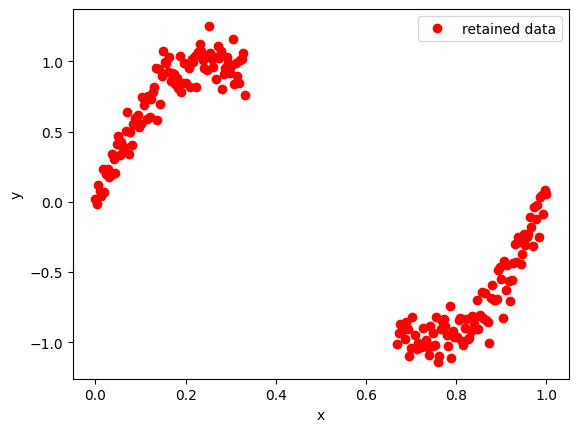

In [23]:
# Plot the data
plt.plot(X_retained, y_retained, 'ro', label='retained data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Fitting model on the retained data for reference

In [24]:
# Creating a neural network with 1 hidden layer
retained_data_model = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.Tanh(),
    torch.nn.Linear(5, 1),
)

In [25]:
# Training the model
optimizer = torch.optim.Adam(retained_data_model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = retained_data_model(X_retained)
    loss_fn(y_pred, y_retained).backward()
    optimizer.step()

In [26]:
list(retained_data_model.parameters())

[Parameter containing:
 tensor([[-1.1729],
         [ 4.3778],
         [-3.6309],
         [ 0.8652],
         [-3.5526]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1116,  0.3930,  1.8292, -0.5016,  3.8590], requires_grad=True),
 Parameter containing:
 tensor([[-1.1789,  1.2528,  3.1484,  3.7503, -1.6007]], requires_grad=True),
 Parameter containing:
 tensor([0.0160], requires_grad=True)]

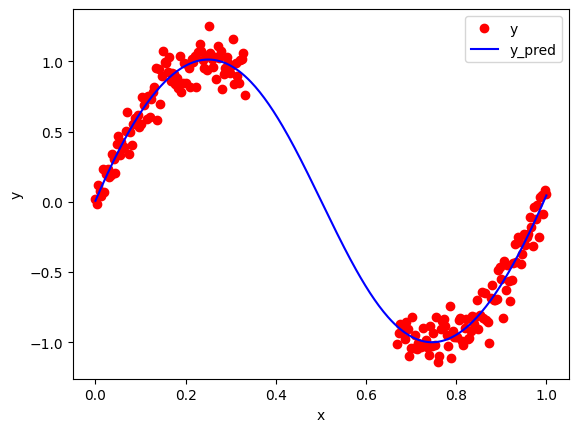

In [27]:
# Plotting the predictions of the neural network
y_pred = retained_data_model(X)

plt.plot(X_retained, y_retained, 'ro', label='y')
plt.plot(X, y_pred.detach().numpy(), 'b-', label='y_pred')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [28]:
# Fitting a Laplace approximation to the neural network
train_retained_dataset = torch.utils.data.TensorDataset(X_retained, y_retained)
train_loader = torch.utils.data.DataLoader(train_retained_dataset, batch_size=50, shuffle=True)
retained_data_model_la = Laplace(retained_data_model, likelihood = 'regression', subset_of_weights='all', hessian_structure='full')
retained_data_model_la.fit(train_loader)
retained_data_model_la.optimize_prior_precision()


In [29]:
# Posterior predictive distribution
x_test = torch.linspace(-0.5, 1.5, 400)
test_mean, test_var = retained_data_model_la(x_test.float().reshape(-1, 1))

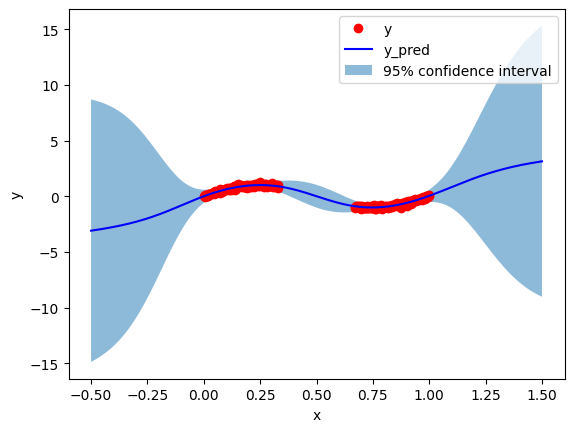

In [30]:
# Plot the predictions of the Laplace approximation and use the test_var to plot the 95% confidence interval
plt.plot(X_retained, y_retained, 'ro', label='y')
plt.plot(x_test, test_mean.detach().numpy(), 'b-', label='y_pred')

conf_int = 1.96 * np.sqrt(test_var.detach().numpy())
# Making conf_int into a column vector
conf_int = conf_int.reshape(-1, 1)

plt.fill_between(x_test, (test_mean.detach().numpy() - conf_int).reshape(-1), (test_mean.detach().numpy() + conf_int).reshape(-1), alpha=0.5, label = '95% confidence interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Laplace Bayesian Unlearning

In [31]:
# Posterior mode of the weights
la.mean

tensor([ 3.5049,  3.9006, -1.2160,  4.1334, -1.3327, -3.7856, -1.9569, -1.0991,
         0.0496,  1.3223,  2.0889, -2.1488, -0.2644,  1.7256, -1.0963,  0.6912])

In [32]:
cov = torch.diag(la.posterior_covariance.diagonal())
cov.shape

torch.Size([16, 16])

In [33]:
# Creating the posterior gaussian distribution of the weights

# Get cov by taking the diagonal elements from the posterior covariance matrix and creating a diagonal matrix from them
# cov = torch.diag(la.posterior_covariance.diagonal())

precision = torch.inverse(cov)

# posterior = dist.multivariate_normal.MultivariateNormal(la.mean, cov)

In [73]:
# Creating a copy of the model
unlearned_model = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.Tanh(),
    torch.nn.Linear(5, 1),
)

In [74]:
lambda_L = 1000

In [75]:
# # Defining the loss function to find out the mode of updated poseterior distribution
# # Create a copy of the model

# def log_likelihood(model):
#     y_pred = model(X_deleted)
#     value = dist.Normal(y_pred, 0.1).log_prob(y_deleted).sum()
#     return value

# def log_q(model):
#     log_prob_posterior = 0.0
#     index = 0
#     # Create a loop to iterate over the parameters of the model using an interger index
#     for params in model.parameters():
#         # Make the params into a 1D vector
#         params = params.reshape(-1)
#         for param in params:
#             mean_value = la.mean[index]
#             scale = torch.sqrt(cov[index][index])
#             log_prob_posterior += dist.Normal(mean_value, scale).log_prob(param)
#             index += 1
#     return log_prob_posterior

# def loss_fn(model):
#     return -log_likelihood(model) + lambda_L * log_q(model)

# Defining the loss function to find out the mode of updated poseterior distribution
# Create a copy of the model

def log_likelihood():
    y_pred = unlearned_model(X_deleted)
    value = dist.Normal(y_pred, 0.1).log_prob(y_deleted).sum()
    return value

def log_q():
    log_prob_posterior = 0.0
    index = 0
    # Create a loop to iterate over the parameters of the model using an interger index
    for params in unlearned_model.parameters():
        # Make the params into a 1D vector
        params = params.reshape(-1)
        for param in params:
            mean_value = la.mean[index]
            scale = torch.sqrt(cov[index][index])
            log_prob_posterior += dist.Normal(mean_value, scale).log_prob(param)
            index += 1
    return log_prob_posterior

def loss_fn():
    return log_likelihood() - lambda_L * log_q()

In [76]:
# Creating a tensor of the parameters of the model for gradient descent
params = list(unlearned_model.parameters())

In [77]:
jtu.tree_leaves(params)

[Parameter containing:
 tensor([[-0.9327],
         [-0.6568],
         [-0.3329],
         [ 0.1564],
         [-0.8799]], requires_grad=True),
 Parameter containing:
 tensor([-0.4309, -0.5987,  0.0028, -0.3721, -0.0693], requires_grad=True),
 Parameter containing:
 tensor([[-0.3030, -0.3070, -0.2609, -0.1531, -0.3530]], requires_grad=True),
 Parameter containing:
 tensor([0.3750], requires_grad=True)]

In [78]:
# Finding the mode of the updated posterior distribution using gradient descent
optimizer = torch.optim.Adam(params, lr=0.02)
for i in range(10000):
    optimizer.zero_grad()
    loss = loss_fn()
    if(i % 1000 == 0):
        print(loss)
    loss.backward()
    optimizer.step()

theta_L_BUN = params

tensor(30010.9102, grad_fn=<SubBackward0>)
tensor(-1.8052e+08, grad_fn=<SubBackward0>)
tensor(-6.6183e+08, grad_fn=<SubBackward0>)
tensor(-1.3719e+09, grad_fn=<SubBackward0>)
tensor(-2.2747e+09, grad_fn=<SubBackward0>)
tensor(-3.3523e+09, grad_fn=<SubBackward0>)
tensor(-4.5958e+09, grad_fn=<SubBackward0>)
tensor(-6.0006e+09, grad_fn=<SubBackward0>)
tensor(-7.5640e+09, grad_fn=<SubBackward0>)
tensor(-9.2842e+09, grad_fn=<SubBackward0>)


In [79]:
theta_L_BUN

[Parameter containing:
 tensor([[ 1.3153],
         [-2.8397],
         [-3.6987],
         [-6.4279],
         [-4.6619]], requires_grad=True),
 Parameter containing:
 tensor([-9.0593, -6.3470, -6.9202, -4.8940, -6.2820], requires_grad=True),
 Parameter containing:
 tensor([[-249.2883, -249.2701, -249.3274, -249.2091, -249.3650]],
        requires_grad=True),
 Parameter containing:
 tensor([249.3099], requires_grad=True)]

In [80]:
# Predicting on the new unlearned posterior distribution
x_test = torch.linspace(0, 1, 300)
y_pred = unlearned_model(x_test.reshape(-1, 1))

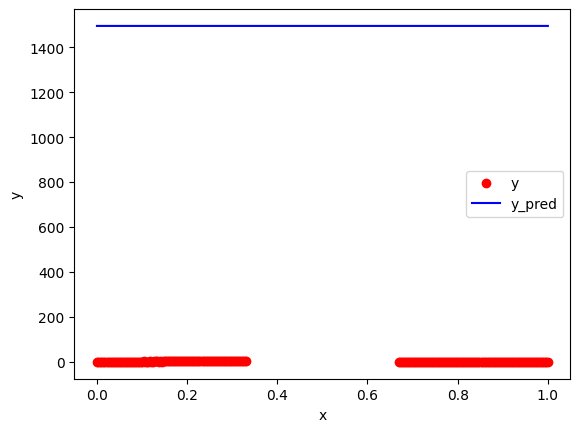

In [81]:
# Plotting the predictions of the unlearned posterior distribution
plt.plot(X_retained, y_retained, 'ro', label='y')
plt.plot(x_test, y_pred.detach().numpy(), 'b-', label='y_pred')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [167]:
torch.autograd.functional.hessian?

## Finding the hessian might be difficult as we need to create a scalar function that takes in tensor inputs and returns a tensor with a single value
## Currently, we pass the model itself and calculate the likelihood with the forward pass
## We can try passing the argument and not using it in the function, directly using the model itself.

Signature:
torch.autograd.functional.hessian(
    func,
    inputs,
    create_graph=False,
    strict=False,
    vectorize=False,
    outer_jacobian_strategy='reverse-mode',
)
Docstring:
Function that computes the Hessian of a given scalar function.

Args:
    func (function): a Python function that takes Tensor inputs and returns
        a Tensor with a single element.
    inputs (tuple of Tensors or Tensor): inputs to the function ``func``.
    create_graph (bool, optional): If ``True``, the Hessian will be computed in
        a differentiable manner. Note that when ``strict`` is ``False``, the result can not
        require gradients or be disconnected from the inputs.
        Defaults to ``False``.
    strict (bool, optional): If ``True``, an error will be raised when we detect that there exists an input
        such that all the outputs are independent of it. If ``False``, we return a Tensor of zeros as the
        hessian for said inputs, which is the expected mathematical value

In [181]:
# Finding the precision matrix of the updated posterior distribution
precision_L_BUN = precision + torch.autograd.functional.hessian(log_likelihood, torch.tensor(1.0))

In [184]:
# torch.autograd.functional.hessian(log_likelihood, torch.tensor(1.0))

tensor(0.)

In [34]:
torch.autograd.functional.hessian(log_likelihood, torch.tensor(theta_L_BUN))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [32]:
precision_L_BUN

tensor([[0.0457, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0465, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0479,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0481, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0465, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0517]])

In [34]:
## Constructing a similar neural network as before
nn_model = torch.nn.Sequential(
    torch.nn.Linear(1, 5),
    torch.nn.Tanh(),
    torch.nn.Linear(5, 1),
)

In [35]:
nn_model.parameters = theta_L_BUN

In [94]:
nn_model.parameters == theta_L_BUN

False

In [81]:
# Initializing the parameters of the neural network with the mode of the updated posterior distribution
nn_model[0].weight = torch.nn.Parameter(torch.tensor(theta_L_BUN[0:5].reshape(5, 1)))
nn_model[0].bias = torch.nn.Parameter(torch.tensor(theta_L_BUN[5:10]))
nn_model[2].weight = torch.nn.Parameter(torch.tensor(theta_L_BUN[10:15].reshape(1, 5)))
nn_model[2].bias = torch.nn.Parameter(torch.tensor(theta_L_BUN[15:16]))

AttributeError: 'list' object has no attribute 'reshape'

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

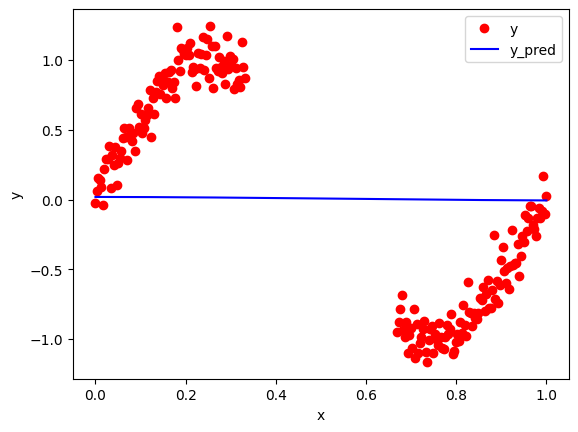

In [36]:
# Predict using this neural network
y_pred = nn_model(X)

# Plot the predictions of the neural network
plt.plot(X_subset, y_subset, 'ro', label='y')
plt.plot(X, y_pred.detach().numpy(), 'b-', label='y_pred')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [142]:
la_ret = Laplace(nn_model, likelihood = 'regression', subset_of_weights='all', hessian_structure='full')

In [135]:
la_ret.posterior_precision = precision_L_BUN

AttributeError: can't set attribute 'posterior_precision'

In [144]:
test_mean, test_var = la_ret(x_test.float().reshape(-1, 1))

AttributeError: 'Sequential' object has no attribute 'output_size'

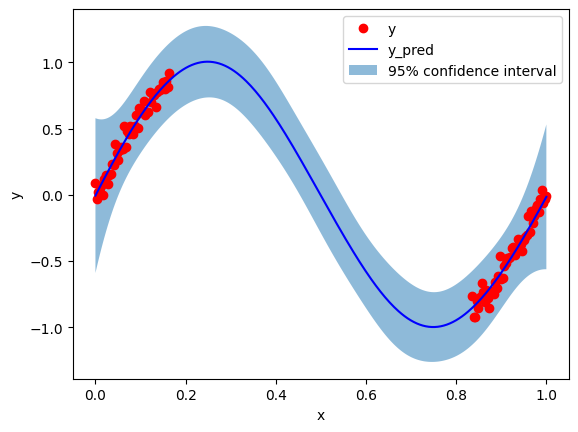

In [138]:
# Plot the predictions of the Laplace approximation and use the test_var to plot the 95% confidence interval
plt.plot(X_subset, y_subset, 'ro', label='y')
plt.plot(x_test, test_mean.detach().numpy(), 'b-', label='y_pred')

conf_int = 1.96 * np.sqrt(test_var.detach().numpy())
# Making conf_int into a column vector
conf_int = conf_int.reshape(-1, 1)

plt.fill_between(x_test, (test_mean.detach().numpy() - conf_int).reshape(-1), (test_mean.detach().numpy() + conf_int).reshape(-1), alpha=0.5, label = '95% confidence interval')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()